# $$\textbf{Binary phase evaluation}$$

We model a binary system embedded in an accretion disk, along with a dark matter spike and gravitational waves emission.
The goal for our modelization is to produce an estimate of the following quantity: 

\begin{equation}
    \dot{r} = \dot{r}_{\mathrm{gas}} + \dot{r}_{\mathrm{DF}} + \dot{r}_{\mathrm{GW}}\text{,}
\end{equation}

where $\dot{r}_\mathrm{gas}$ is the contribution coming from gas torques from the accretion disk surrounding the binary, $\dot{r}_\mathrm{DF}$ is the effect of dynamical friction from the presence of the dark matter spike, and $\dot{r}_\mathrm{GW}$ is the contribution from the gravitational waves emission. Specifically, we adopt the classical Newtonian formalism, computing the results from the reduced mass-system, and in case assuming that $m_1 \gg m_2$.

Once the shape of $\dot{r}$ is clear, one can evaluate the phase of the binary system from a generic $f$-frequency to the $f_{\mathrm{isco}}$-frequency. Assuming circular orbits the frequency is:

\begin{equation}
    f = \frac{1}{\pi} \sqrt{\frac{G(m_1 + m_2)}{r^3}}\text{.}
\end{equation}

We can evaluate $\Phi(f)$ as: 

\begin{equation}
    \Phi(f) = 2\pi \int_{f}^{f_{\mathrm{isco}}} \frac{dt}{df'} f' df'\text{,}
\end{equation}

where the relation $\frac{dt}{df'}$ is extracted directly from the expression in the above equation by the following chain rule: $\frac{dr}{dt} \frac{df}{dr} = \frac{df}{dt}$. 

### Note!

If we already integrate on the grid that starts from $\textit{isco}$ we are subtracting the $\Phi(f_{\mathrm{isco}}) = \int_{f_{\mathrm{isco}}}^{f_{\mathrm{isco}}} \frac{dt}{df} f' df' = 0$ to the phase $\Phi(f)$.

## Expressions for the $\dot{r}_i$ contributions

- Accretion disk's torques: 

\begin{equation}
    \dot{r}_\mathrm{gas} = - 2 \Sigma_0 \frac{r^{\gamma + 3/2}}{r_0^\gamma} \frac{G^{1/2} (m_1 + m_2)^{1/2}}{\mu} q^{2} \mathcal{M}^2\text{.}
\end{equation}

- Dark matter spike's dynamical friction:

Static:

\begin{equation}
\label{eq:r_dot_DF}
    \dot{r}_{\mathrm{DF}} = - \frac{8 \pi G^{\frac{1}{2}} \mu \log{(\Lambda)} \rho_6 r_6^{\gamma_s} \xi(v)}{r^{\gamma_s - \frac{5}{2}}(m_1 + m_2)^{\frac{3}{2}}}\text{,}
\end{equation}

- Gravitational waves: 

\begin{equation}
\label{eq:r_dot_gw}
    \dot{r}_{\mathrm{GW}} = - \frac{64 (m_1 + m_2) G^3 m_1 m_2}{5 c^5 r^3}\text{.}
\end{equation}

In the code, there will be enabled the possibility to choose which of these options to keep in the final formula, which will account for the sum of all the contributions the user requires. 

## Formulas to use and implement "in code" for the phase evaluation

I used the following quantities: 

- Derivative of f in radial separation:

\begin{equation}
\label{eq:dfdr}
    \frac{df}{dr} = \frac{1}{\pi} (-\frac{3}{2}) \sqrt{\frac{G (m_1 + m_2)}{r^5}}\text{.}\\
\end{equation}


- Inverse of f(r):

\begin{equation}
\label{eq:r(f)}
    r(f) = \sqrt[3]{\frac{G (m_1 + m_2)}{\pi^2 f^2}}\text{,}\\
\end{equation}

- Derivative of f in time:

\begin{equation}
\label{eq:dfdt}
    \frac{df}{dt} = \dot{r} \frac{df}{dr}\text{,}\\
\end{equation}

- Second derivative of the phase in time:

\begin{equation}
\label{eq:phi_dot-dot}
    \ddot{\Phi}(f) = 4 \pi^2 f \left(\frac{d\Phi(f)}{df}\right)^{-1} 
\end{equation}

# Code implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scipy as sp
from scipy.integrate import quad_vec, simps 
from scipy.special import hyp2f1, betainc
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.integrate import cumulative_trapezoid

In [2]:
# Define some constants: 

G = 6.67408e-11 # kg^-1 m^3 / s^2
c = 299792458.0 # m / s
pc = 3.08567758149137e16 # m
m_sun = 1.98855e30 # kg

## General functions

Below we find a bunch of functions to perform useful operations throughout the code.

- To find the analytical phase to coalescence:

In [3]:
def hypgeom_scipy(theta, y):
        '''Compute the hypergeometric function using scipy.'''
        return hyp2f1(1, theta, 1 + theta, -y**(-5 / (3*theta)))

def hyp2f1_derivative(hyp2f1, f):
        '''Finds derivative of the gauss_hypergeom function through differentiation.'''
        delta_function = np.concatenate(([np.min(hyp2f1)], hyp2f1[1:] - hyp2f1[:-1]))
        delta_fs = np.concatenate(([np.max(f)], f[1:] - f[:-1]))
        return delta_function/delta_fs
    
def find_cf(m1, gammas, M_tot, r_s, rho_s, epsv, logL):

    return 5 * c**5 / (8 * m1**2) * np.pi**(2 * (gammas - 4) / 3) * G**(-(2 + gammas) / 3) * M_tot**((1 - gammas)/3) * r_s**(gammas) * epsv * rho_s * logL

- To find the numerical phase to coalescence

In [4]:
def df_dt(df_dr, dot_r): 
    '''Finds the binary frequency time derivative.'''
    return df_dr * dot_r
    
def phase_f_by_hand(f, df_dt): 
    '''Finds the binary phase as a function of frequency.'''
    to_integrate = 2 * np.pi * df_dt**(-1) * f 
    phase_f = []
    for b in f:  # range of values for the lower limit
        # Select the appropriate range of f values for integration
        f_range = f[f >= b]
        phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
    return np.array(phase_f)

def phase_f(f, df_dt):
    '''Finds the binary phase as a function of frequency.'''
    to_integrate = 2 * np.pi * df_dt**(-1) * f 

    # Compute the cumulative integral of the function using trapezoidal rule --> much faster way
    phase_f = cumulative_trapezoid(to_integrate, x=f, initial=0)
    
    return phase_f

- From the $\texttt{pydd}$ code on GitHub (
https://github.com/pipcole/pydd/blob/main/src/pydd/binary.py#L45 
):

In [5]:
# Conversion functions

def get_r_s(m_1, rho_s, gamma_s):
    return ((3 - gamma_s) * 0.2 ** (3 - gamma_s) * m_1 / (2 * np.pi * rho_s)) ** (1 / 3)
    
def get_rho_s(rho_6, m_1, gamma_s):
    a = 0.2
    r_6 = 1e-6 * pc
    m_tilde = ((3 - gamma_s) * a ** (3 - gamma_s)) * m_1 / (2 * np.pi)
    return (rho_6 * r_6 ** gamma_s / (m_tilde ** (gamma_s / 3))) ** (1 / (1 - gamma_s / 3))

def get_rho_6(rho_s, m_1, gamma_s):
    a = 0.2
    r_s = ((3 - gamma_s) * a ** (3 - gamma_s) * m_1 / (2 * np.pi * rho_s)) ** (1 / 3)
    r_6 = 1e-6 * pc
    return rho_s * (r_6 / r_s) ** -gamma_s

## Environments 

I below will implement a class for each of the environment of study. This will allow me to compute the different $\dot{r}$ separately, and then use them in a more general function evaluating the phase to coalescence.

### Vacuum Binary

In [6]:
class VacuumBinary:
    
    """
    VacuumBinary

    Overview:
    Initializes an environment for a vacuum binary system, evaluates the derivative of the radius, and aids in finding the phase to coalescence of the binary system.

    Attributes:
    ----------
    m1 : float
        Mass of the first body in kilograms.
    
    m2 : float
        Mass of the second body in kilograms.
    
    mu : float
        Reduced mass of the binary system.
    
    q : float
        Mass ratio of the binary system (m2/m1).
    
    M_tot : float
        Total mass of the binary system.
    
    dist : float
        Distance to the binary system.
    
    chirp_mass : float
        Chirp mass of the binary system, relevant for gravitational wave calculations.

    Methods:
    -------
    frequency(r: float) -> float
        Finds the binary frequency assuming circular orbits, at fixed radius r.

    radius(f: float) -> float
        Finds the binary radius assuming circular orbits, at fixed frequency f.

    df_dr(r: float) -> float
        Finds the binary frequency radial derivative assuming circular orbits.

    vacuum_phase(r: float) -> float
        Analytical vacuum phase solution, integral from frequency to innermost stable circular orbit (ISCO) frequency.

    dvacuum_phase_df(r: float) -> float
        Analytical derivative of the vacuum phase solution with respect to frequency.

    dot_r_gw(r: float) -> float
        Finds the derivative of radial separation in the vacuum case.

    Examples:
    --------
    >>> binary = VacuumBinary(1.4 * 1.989e30, 1.4 * 1.989e30, 1e20)
    >>> r = 1e7  # example radius
    >>> freq = binary.frequency(r)
    >>> phase = binary.vacuum_phase(r)
    >>> dr_dt = binary.dot_r_gw(r)
    """
    
    def __init__(self, m1, m2, dist): 
        
        """
        Initializes the VacuumBinary class.

        Parameters:
        ----------
        m1 : float
            Mass of the first body in kilograms.
        
        m2 : float
            Mass of the second body in kilograms.
        
        dist : float
            Distance to the binary system.
        """
        
        self.m1 = m1
        self.m2 = m2
        self.mu = self.m1 * self.m2 / (self.m1 + self.m2)
        self.q = self.m2/self.m1
        self.M_tot = self.m1 + self.m2
        self.dist = dist
        self.chirp_mass = (self.m1 * self.m2)**(3/5) / (self.M_tot)**(1/5)   
    
    def frequency(self, r):
        return 1 / np.pi * np.sqrt(G * self.M_tot / r**3)
    
    def radius(self, f):
        return (G * self.M_tot / (f**2 * np.pi**2))**(1/3)
    
    def df_dr(self, r): 
        return 1 / np.pi * (-3/2) * np.sqrt(G * self.M_tot / r**5)
    
    def vacuum_phase(self, r):
        freqs = self.frequency(r)
        r_isco = 6 * self.m1 * G / c**2
        f_isco = self.frequency(r_isco)
        return 1/16 * (c**3 / (np.pi * G * self.chirp_mass))**(5/3) * (-freqs**(-5/3) + f_isco**(-5/3))
    
    def dvacuum_phase_df(self, r):
        freqs = self.frequency(r)
        return 1/16 * (c**3 / (np.pi * G * self.chirp_mass))**(5/3) * (-5/3) * (-freqs**(-5/3-1))
    
    def dot_r_gw(self, r):
        return - 64 * self.M_tot * G**3 * self.m1 * self.m2 / (5 * c**5 * r**3)
        

### Accretion Disk

In [7]:
class AccretionDisk: 
    
    """
    AccretionDisk

    Overview:
    Initializes an environment for a binary system embedded in an accretion disk, evaluates the surface density and density profile of the disk, and calculates torques and radial separation derivatives within the disk.

    Attributes:
    ----------
    Binary_init : VacuumBinary
        An instance of the VacuumBinary class representing the binary system.

    mach : float
        Mach number characterizing the disk.

    sigma0 : float
        Surface density normalization constant.

    alpha : float
        Power-law index for the surface density profile.

    r0 : float
        Reference radius for the surface density normalization.

    Methods:
    -------
    sigma_acc(r: float) -> float
        Finds the surface density profile of an accretion disk.

    rho_disk(r: float) -> float
        Finds the density profile of the disk using \rho ≈ Σ(r) / (2h), where h = r / Mach.

    gas_torque(r: float) -> float
        Finds the gas torque on the secondary component of the binary.

    dot_r_acc(r: float) -> float
        Finds the derivative of radial separation within an accretion disk.

    Examples:
    --------
    >>> disk = AccretionDisk(1.4 * 1.989e30, 1.4 * 1.989e30, 1e20, 10, 1e3, -1, 1e9)
    >>> r = 1e7  # example radius
    >>> sigma = disk.sigma_acc(r)
    >>> rho = disk.rho_disk(r)
    >>> torque = disk.gas_torque(r)
    >>> dr_dt = disk.dot_r_acc(r)
    """
    
    def __init__(self, m1, m2, dist, mach, sigma0, alpha, r0):
        
        """
        Initializes the AccretionDisk class.

        Parameters:
        ----------
        m1 : float
            Mass of the first body in kilograms.
        
        m2 : float
            Mass of the second body in kilograms.
        
        dist : float
            Distance to the binary system.
        
        mach : float
            Mach number characterizing the disk.
        
        sigma0 : float
            Surface density normalization constant.
        
        alpha : float
            Power-law index for the surface density profile.
        
        r0 : float
            Reference radius for the surface density normalization.
        """
        
        self.Binary_init = VacuumBinary(m1 = m1, m2 = m2, dist = dist)
        self.mach = mach
        self.sigma0 = sigma0
        self.alpha = alpha
        self.r0 = r0
        
    def sigma_acc(self, r):
        return self.sigma0 * (r / self.r0)**(self.alpha)

    def rho_disk(self, r):
        h = r / self.mach
        return self.sigma_acc(r) / (2 * h) 
    
    def gas_torque(self, r):
        omega_2 = G * self.Binary_init.M_tot / r**3
        return - self.sigma_acc(r) * r**4 * self.Binary_init.q**2 * self.mach**2
    
    def dot_r_acc(self, r):
        r_dot_acc = 2 * self.gas_torque(r) / self.Binary_init.mu * np.sqrt(r / (G * self.Binary_init.M_tot))
        return r_dot_acc

In [8]:
class DarkMatter: 
    
    """
    DarkMatter

    Overview:
    Initializes an environment for a binary system embedded in a dark matter spike, evaluates the dark matter density profile, and calculates the radial separation derivatives in a dark matter environment.

    Attributes:
    ----------
    Binary_init : VacuumBinary
        An instance of the VacuumBinary class representing the binary system.

    logL : float
        The Coulomb logarithm.

    gammas : float
        Slope of the dark matter density profile.

    rho6 : float
        Density normalization constant at radius r6.

    r6 : float
        Reference radius for the density normalization.

    epsv : float
        Velocity dispersion parameter.

    Methods:
    -------
    rho_dm(r: float) -> float
        Finds the density profile of the dark matter using the specified formulation.

    dot_r_dm_s(r: float) -> float
        Finds the derivative of radial separation within a static dark matter environment.

    dot_r_dm_eff(r: float) -> float
        Finds the derivative of radial separation considering an effective dark matter environment from previous numerical fits on the HaloFeedback algorithm.

    Examples:
    --------
    >>> dm = DarkMatter(1.4 * 1.989e30, 1.4 * 1.989e30, 1e20, 0.1, 1e-2, 1e3, 1e9, 0.1)
    >>> r = 1e7  # example radius
    >>> rho = dm.rho_dm(r)
    >>> dr_dt_s = dm.dot_r_dm_s(r)
    >>> dr_dt_eff = dm.dot_r_dm_eff(r)
    """
    
    def __init__(self, m1, m2, dist, q, gammas, rho6, r6, epsv):
        
        """
        Initializes the DarkMatter class.

        Parameters:
        ----------
        m1 : float
            Mass of the first body in kilograms.
        
        m2 : float
            Mass of the second body in kilograms.
        
        dist : float
            Distance to the binary system.
        
        q : float
            Mass ratio parameter.

        gammas : float
            Slope of the dark matter density profile.
        
        rho6 : float
            Density normalization constant at radius r6.
        
        r6 : float
            Reference radius for the density normalization.
        
        epsv : float
            Velocity dispersion parameter.
        """
    
        self.Binary_init = VacuumBinary(m1 = m1, m2 = m2, dist = dist)
        self.logL = 1 / np.sqrt(q)
        self.gammas = gammas
        self.rho6 = rho6
        self.r6 = r6
        self.epsv = epsv
    
    def rho_dm(self, r):
        return self.rho6 * (self.r6 / r)**(self.gammas)
    
    def dot_r_dm_s(self, r):
        r_dot_dm = - 8 * np.pi * G**(1/2) * self.Binary_init.mu * self.logL * self.rho_dm(r) * r**(5/2) * self.epsv / self.Binary_init.M_tot**(3/2)
        return r_dot_dm
    
    def dot_r_dm_eff(self, r):

        freqs = self.Binary_init.frequency(r)
        df_dr_s = self.Binary_init.df_dr(r)
        
        # Vacuum 
        
        phase_vacuum = self.Binary_init.vacuum_phase(r)
        dphase_vacuum_df = self.Binary_init.dvacuum_phase_df(r)
        
        # Constants
        
        rho_s = get_rho_s(self.rho6, self.Binary_init.m1, self.gammas)
        r_s = get_r_s(self.Binary_init.m1, rho_s, self.gammas)
        
        gamma_e = 5/2 
        cf = find_cf(self.Binary_init.m1, self.gammas, self.Binary_init.M_tot, r_s, rho_s, self.epsv, self.logL)
        f_eq = cf**(3 / (11 - 2 * self.gammas))
        theta = 5 / (2 * gamma_e)
        lambda_ = (11 - 2 * (self.gammas + gamma_e)) / 3
        
        alpha_1 = 1.4412
        alpha_2 = 0.4511
        beta = 0.8163
        xi = - 0.4971
        gamma_r = 1.4396
        f_b = beta * (self.Binary_init.m1 / (1000 * m_sun))**(-alpha_1) * (self.Binary_init.m2 / m_sun)**(alpha_2) * (1 + xi * np.log(self.gammas/gamma_r))
        
        f_t = f_b
        eta = (5 + 2*gamma_e) / (2 * (8 - self.gammas)) * (f_eq / f_b)**((11 - 2 * self.gammas) / 3)
        
        # Variables 
    
        y = freqs / f_t
        dy_df = 1 / f_t
        
        # Hypergeometric function
        
        gauss_hypergeom = hyp2f1(1, theta, 1 + theta, - y**(-5/(3 * theta)))
        dgauss_hypergeom_df = hyp2f1_derivative(gauss_hypergeom, freqs)
        
        # Find phase derivative in frequency
        
        exp_y = y**(-lambda_)
        d_phase_df_s = dphase_vacuum_df - (dphase_vacuum_df * eta * exp_y + phase_vacuum * eta * (-lambda_) * exp_y/y * dy_df) + eta * (-lambda_ * exp_y/y * phase_vacuum * dy_df * gauss_hypergeom + exp_y * dphase_vacuum_df * gauss_hypergeom + exp_y * phase_vacuum * dgauss_hypergeom_df)
        
        df_dt = 2 * np.pi * freqs / d_phase_df_s
        
        return df_dt * df_dr_s**(-1)

In [9]:
class Phase_Evaluation_check: 
    
    """
    Phase_Evaluation_check

    Overview:
    This class initializes various environments for a binary system, including vacuum, accretion disk, and dark matter spike, and evaluates the phase to coalescence for each environment.

    Attributes:
    ----------
    Binary_init : VacuumBinary
        An instance of the VacuumBinary class representing the binary system.

    Acc_init : AccretionDisk
        An instance of the AccretionDisk class representing the binary system within an accretion disk environment.

    DM_init : DarkMatter
        An instance of the DarkMatter class representing the binary system within a dark matter spike environment.

    Methods:
    -------
    _Phi_to_c_indef_s(r: float) -> float
        Compute indefinite phase to coalescence for static dark matter.

    _Phi_to_c_s(r: float) -> float
        Compute phase to coalescence for static dark matter.

    _Phi_to_c_indef_v(r: float) -> float
        Compute indefinite phase to coalescence for vacuum.

    _Phi_to_c_v(r: float) -> float
        Compute phase to coalescence for vacuum.

    phase_effective_dm(r: float) -> float
        Finds the effective phase from fitting results from the HaloFeedback algorithm.

    Examples:
    --------
    >>> pec = Phase_Evaluation_check(m1=1.4 * 1.989e30, m2=1.4 * 1.989e30, dist=4e9, mach=10, sigma0=1e-2, alpha=0.5, gammas=1, rho6=1e3, r6=1e2, r0=1e7, epsv=0.1)
    >>> r = 1e7  # example radius
    >>> phi_vacuum = pec._Phi_to_c_v(r)
    >>> phi_static_dm = pec._Phi_to_c_s(r)
    >>> phi_effective_dm = pec.phase_effective_dm(r)
    """
    
    def __init__(self, m1, m2, dist, mach, sigma0, alpha, gammas, rho6, r6, r0, epsv): 
        
        """
        Initializes the Phase_Evaluation_check class.

        Parameters:
        ----------
        m1 : float
            Mass of the first body in kilograms.
        
        m2 : float
            Mass of the second body in kilograms.
        
        dist : float
            Distance to the binary system.
        
        mach : float
            Mach number of the accretion disk.
        
        sigma0 : float
            Surface density normalization constant of the accretion disk.
        
        alpha : float
            Power-law index of the surface density profile of the accretion disk.
        
        gammas : float
            Slope of the dark matter density profile.
        
        rho6 : float
            Density normalization constant at radius r6 for the dark matter.
        
        r6 : float
            Reference radius for the dark matter density normalization.
        
        r0 : float
            Reference radius for the accretion disk.
        
        epsv : float
            Velocity dispersion parameter for the dark matter.
        """
        
        self.Binary_init = VacuumBinary(m1 = m1, m2 = m2, dist = dist)
        
        self.Acc_init = AccretionDisk(mach=mach, 
                           m1=m1,
                           m2=m2, 
                           dist=4e9,
                           sigma0=sigma0, 
                           alpha=alpha, 
                            r0=r0)

        self.DM_init = DarkMatter(m1=m1, 
                        m2=m2, 
                        dist=4e9, 
                        q=m2/m1, 
                        gammas=gammas, 
                        rho6=rho6, 
                        r6=r6, 
                        epsv=epsv)

    def _Phi_to_c_indef_s(self, r):
        '''Compute indefinite phase to coalescence for static dm.'''
        freqs = self.Binary_init.frequency(r)
        
        rho_s = get_rho_s(self.DM_init.rho6, self.Binary_init.m1, self.DM_init.gammas)
        r_s = get_r_s(self.Binary_init.m1, rho_s, self.DM_init.gammas)
        
        y = freqs / (find_cf(self.Binary_init.m1, self.DM_init.gammas, self.Binary_init.M_tot, r_s, rho_s, self.DM_init.epsv, self.DM_init.logL)**(3 / (11 - 2 * self.DM_init.gammas)))
        a_v = 1 / 16 * (c ** 3 / (np.pi * G * self.Binary_init.chirp_mass)) ** (5/3)
        theta = 5 / (11 - 2 * self.DM_init.gammas)
        
        return a_v / freqs ** (5 / 3) * hypgeom_scipy(theta, y)
    
    
    def _Phi_to_c_s(self, r):
        '''Compute phase to coalescence for static dm.'''
        r_isco = 6 * self.Binary_init.m1 * G / c**2
        return self._Phi_to_c_indef_s(r) -  self._Phi_to_c_indef_s(r_isco)
    
    def _Phi_to_c_indef_v(self, r):
        '''Compute indefinite phase to coalescence for vacuum.'''
        freqs = self.Binary_init.frequency(r)
        a_v = 1/16 * (c ** 3 / (np.pi * G * self.Binary_init.chirp_mass))**(5/3)
        return a_v / freqs**(5/3)
    
    def _Phi_to_c_v(self, r):
        '''Compute phase to coalescence for vacuum.'''
        r_isco = 6 * self.Binary_init.m1 * G / c**2
        return self._Phi_to_c_indef_v(r) -  self._Phi_to_c_indef_v(r_isco)
    
    def phase_effective_dm(self, r):
    
        '''Finds the effective phase from fitting results from HaloFeedback algorithm.'''
        
        freqs = self.Binary_init.frequency(r)
        
        # Constants
        
        rho_s = get_rho_s(self.DM_init.rho6, self.Binary_init.m1, self.DM_init.gammas)
        r_s = get_r_s(self.Binary_init.m1, rho_s, self.DM_init.gammas)
        
        gamma_e = 5/2 
        cf = find_cf(self.Binary_init.m1, self.DM_init.gammas, self.Binary_init.M_tot, r_s, rho_s, self.DM_init.epsv, self.DM_init.logL)
        f_eq = cf**(3 / (11 - 2 * self.DM_init.gammas))
        theta = 5 / (2 * gamma_e)
        lambda_ = (11 - 2 * (self.DM_init.gammas + gamma_e)) / 3
        
        alpha_1 = 1.4412
        alpha_2 = 0.4511
        beta = 0.8163
        xi = - 0.4971
        gamma_r = 1.4396
        f_b = beta * (self.Binary_init.m1 / (1000 * m_sun))**(-alpha_1) * (self.Binary_init.m2 / m_sun)**(alpha_2) * (1 + xi * np.log(self.DM_init.gammas/gamma_r))
        
        f_t = f_b
        eta = (5 + 2*gamma_e) / (2 * (8 - self.DM_init.gammas)) * (f_eq / f_b)**((11 - 2 * self.DM_init.gammas) / 3)
        
        # Variables:
        
        f_t = f_b
        y = freqs / f_t
        phase_vacuum = self._Phi_to_c_v(r)
        
        # Hypergeometric function
        
        gauss_hypergeom = hyp2f1(1, theta, 1 + theta, - y**(-5/(3 * theta)))
        
        return phase_vacuum * (1 - eta * y**(-lambda_) * (1 - gauss_hypergeom))

---

# Test 1) Reference parameters results

- Set of parameters 1:

In [10]:
# Fix parameters:

m1 = 1e5 * m_sun #1.4e3 * m_sun
m2 = 10 * m_sun #1.4 * m_sun
q = m2/m1
M_tot = m1 + m2
mu = m1 * m2 / M_tot
chirp_mass = (m1 * m2)**(3/5) / (M_tot)**(1/5)

# Fix environments:

# Spike

rho6 = 1.17e17 * m_sun / pc**3
r6 =  pc / 1e6
gammas = 7/3
epsv = 0.58
logL = 1 / q**(1/2)

# Accretion disk

r_s = 2 * G * m1/ c**2 # Schwartzschild radius of m1
r0 = 3 * r_s
Mach = 100 
sigma0 = 1.5e10 / Mach**2
alpha = -1/2

In [11]:
# Initialize system

vacuum_binary = VacuumBinary(
    m1=m1,
    m2=m2,
    dist=4e9 #pc
)

accretion_disk = AccretionDisk(
    mach=Mach, 
    m1=m1,
    m2=m2,
    r0=r0, 
    dist=4e9,
    sigma0=sigma0, 
    alpha=alpha
)

dark_matter = DarkMatter(
    m1=m1, 
    m2=m2, 
    dist=4e9, 
    q=q, 
    gammas=gammas, 
    rho6=rho6, 
    r6=r6, 
    epsv=epsv
)

check = Phase_Evaluation_check(
    m1 = m1, 
    m2 = m2, 
    dist = 4e9, 
    mach = Mach, 
    sigma0 = sigma0, 
    alpha = alpha, 
    gammas = gammas, 
    rho6 = rho6, 
    r6 = r6,
    r0=r0,
    epsv = epsv
)

### Define the domain 

Defining the domain from the lower limit of LISA's sensitivity ($\sim 10^{-3}$), up to ISCO of the system.

In [12]:
# Build grid of vals

f_LISA = 1e-3 # Hz
r_max = vacuum_binary.radius(f_LISA)

r_isco = 6 * m1 * G / c**2
f_isco = vacuum_binary.frequency(r_isco)

print('isco frequency', f_isco)

# set grid of radial distances
r_grid = np.linspace(r_isco, r_max, 10000)

freqs = vacuum_binary.frequency(r_grid)

isco frequency 0.04397229680540114


### Dephasing 

In [13]:
phase_gw = -phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid), vacuum_binary.dot_r_gw(r_grid)))
phase_dm_s = -phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid), dark_matter.dot_r_dm_s(r_grid) + vacuum_binary.dot_r_gw(r_grid)))
phase_acc = -phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid), accretion_disk.dot_r_acc(r_grid) + vacuum_binary.dot_r_gw(r_grid)))
phase_dm_eff = -phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid), dark_matter.dot_r_dm_eff(r_grid)))
phase_all = -phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid), dark_matter.dot_r_dm_s(r_grid) + vacuum_binary.dot_r_gw(r_grid) + accretion_disk.dot_r_acc(r_grid)))

In [14]:
# N_cycles

N_dm_s = (-phase_dm_s + phase_gw)/(2 * np.pi)
N_dm_eff = (-phase_dm_eff + phase_gw)/(2 * np.pi)
N_acc = (-phase_acc + phase_gw)/(2 * np.pi)
N_all = (-phase_all + phase_gw)/(2 * np.pi)

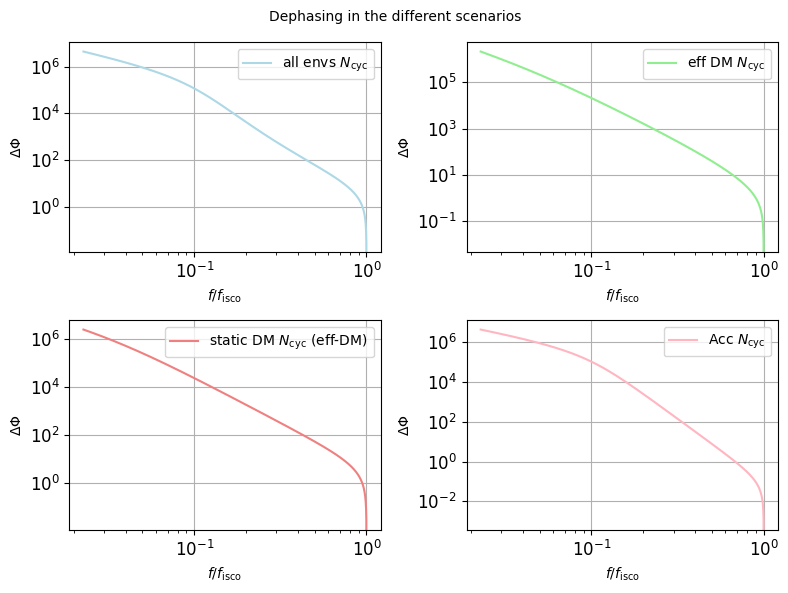

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0, 0].loglog(freqs/f_isco, N_all, c='lightblue', linestyle='-', label='all envs $N_{\mathrm{cyc}}$')
ax[0, 0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[0, 0].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[0, 0].tick_params(axis='x', labelsize=12)  
ax[0, 0].tick_params(axis='y', labelsize=12)  
ax[0, 0].grid(True)
ax[0, 0].legend()

ax[0, 1].loglog(freqs/f_isco, N_dm_eff, c='lightgreen', linestyle='-', label='eff DM $N_{\mathrm{cyc}}$')
ax[0, 1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[0, 1].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[0, 1].tick_params(axis='x', labelsize=12)  
ax[0, 1].tick_params(axis='y', labelsize=12)  
ax[0, 1].grid(True)
ax[0, 1].legend()

ax[1, 0].loglog(freqs/f_isco, N_dm_s, c='lightcoral', linestyle='-', label='static DM $N_{\mathrm{cyc}}$ (eff-DM)')
ax[1, 0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[1, 0].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[1, 0].tick_params(axis='x', labelsize=12)  
ax[1, 0].tick_params(axis='y', labelsize=12)  
ax[1, 0].grid(True)
ax[1, 0].legend()

ax[1, 1].loglog(freqs/f_isco, N_acc, c='lightpink', linestyle='-', label='Acc $N_{\mathrm{cyc}}$')
ax[1, 1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[1, 1].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[1, 1].tick_params(axis='x', labelsize=12)  
ax[1, 1].tick_params(axis='y', labelsize=12)  
ax[1, 1].grid(True)
ax[1, 1].legend()

plt.suptitle('Dephasing in the different scenarios', fontsize=10)
plt.tight_layout()
plt.savefig('results-images/dephasing_effective_1e5.png');

---

- Set of parameters 2:

In [16]:
# Fix parameters:

m1_1 = 1.4e3 * m_sun #1.4e3 * m_sun
m2_1 = 1.4 * m_sun #1.4 * m_sun
q1 = m2_1/m1_1
M_tot1 = m1_1 + m2_1
mu1 = m1_1 * m2_1 / M_tot1
chirp_mass1 = (m1_1 * m2_1)**(3/5) / (M_tot1)**(1/5)

# Fix environments:

# Spike

rho_s = 226 * m_sun / pc**3
r6_1 =  pc / 1e6
gammas1 = 7/3
epsv1 = 0.58
logL1 = 1 / q1**(1/2)

rho6_1 = get_rho_6(rho_s, m1_1, gammas1)


# Accretion disk

r_s1 = 2 * G * m1_1/ c**2 # Schwartzschild radius of m1
r0_1 = 3 * r_s1
Mach1 = 100 
sigma0_1 = 1.5e10 / Mach1**2
alpha1 = -1/2

In [17]:
# Initialize system

vacuum_binary1 = VacuumBinary(
    m1=m1_1,
    m2=m2_1,
    dist=4e9 #pc
)

accretion_disk1 = AccretionDisk(
    mach=Mach1, 
    m1=m1_1,
    m2=m2_1,
    r0=r0_1, 
    dist=4e9,
    sigma0=sigma0_1, 
    alpha=alpha1
)

dark_matter1 = DarkMatter(
    m1=m1_1, 
    m2=m2_1, 
    dist=4e9, 
    q=q1, 
    gammas=gammas1, 
    rho6=rho6_1, 
    r6=r6_1, 
    epsv=epsv1
)

check1 = Phase_Evaluation_check(
    m1 = m1_1, 
    m2 = m2_1, 
    dist = 4e9, 
    mach = Mach1, 
    sigma0 = sigma0_1, 
    alpha = alpha1, 
    gammas = gammas1, 
    rho6 = rho6_1, 
    r6 = r6_1,
    r0=r0_1,
    epsv = epsv1
)

### Define the domain

Defining the domain from the lower limit of LISA's sensitivity ($\sim 10^{-3}$), up to ISCO of the system.

In [18]:
# Build grid of vals

f_LISA = 1e-3 # Hz
r_max1 = vacuum_binary1.radius(f_LISA)

r_isco1 = 6 * m1_1 * G / c**2
f_isco1 = vacuum_binary1.frequency(r_isco1)

print('isco frequency', f_isco1)

# set grid of radial distances
r_grid1 = np.linspace(r_isco1, r_max1, 10000)

freqs1 = vacuum_binary1.frequency(r_grid1)

isco frequency 3.14229127936465


### Dephasing

In [19]:
phase_gw1 = -phase_f(freqs1, df_dt(vacuum_binary1.df_dr(r_grid1), vacuum_binary1.dot_r_gw(r_grid1)))
phase_dm_s1 = -phase_f(freqs1, df_dt(vacuum_binary1.df_dr(r_grid1), dark_matter1.dot_r_dm_s(r_grid1) + vacuum_binary1.dot_r_gw(r_grid1)))
phase_acc1 = -phase_f(freqs1, df_dt(vacuum_binary1.df_dr(r_grid1), accretion_disk1.dot_r_acc(r_grid1) + vacuum_binary1.dot_r_gw(r_grid1)))
phase_dm_eff1 = -phase_f(freqs1, df_dt(vacuum_binary1.df_dr(r_grid1), dark_matter1.dot_r_dm_eff(r_grid1)))
phase_all1 = -phase_f(freqs1, df_dt(vacuum_binary1.df_dr(r_grid1), dark_matter1.dot_r_dm_s(r_grid1) + vacuum_binary1.dot_r_gw(r_grid1) + accretion_disk1.dot_r_acc(r_grid1)))

In [20]:
# N-cycles 

N_dm_s_1 = (-phase_dm_s1 + phase_gw1)/(2 * np.pi)
N_acc_1 = (-phase_acc1 + phase_gw1)/(2 * np.pi)
N_dm_eff_1 = (- phase_dm_eff1 + phase_gw1)/(2 * np.pi)
N_all_1 = (- phase_all1 + phase_gw1)/(2 * np.pi)

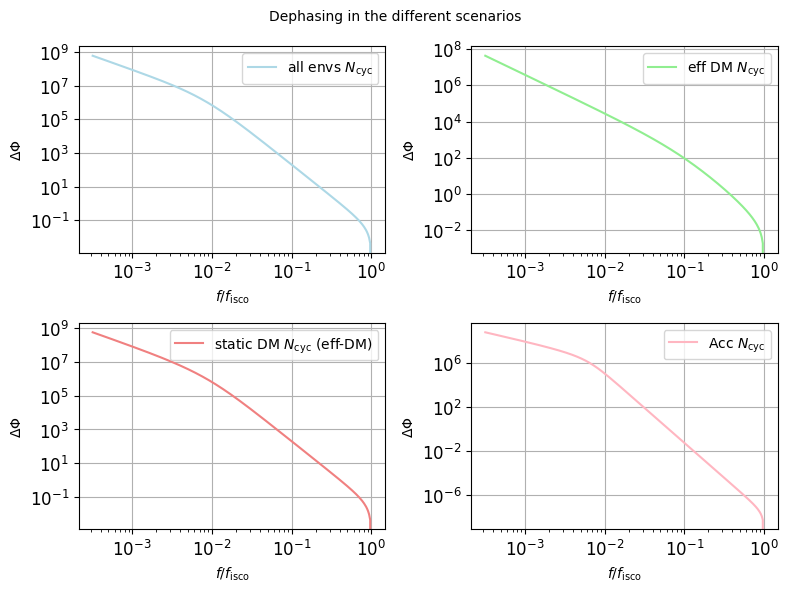

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0, 0].loglog(freqs1/f_isco1, N_all_1, c='lightblue', linestyle='-', label='all envs $N_{\mathrm{cyc}}$')
ax[0, 0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[0, 0].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[0, 0].tick_params(axis='x', labelsize=12)  
ax[0, 0].tick_params(axis='y', labelsize=12)  
ax[0, 0].grid(True)
ax[0, 0].legend()

ax[0, 1].loglog(freqs1/f_isco1, (N_dm_eff_1), c='lightgreen', linestyle='-', label='eff DM $N_{\mathrm{cyc}}$')
ax[0, 1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[0, 1].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[0, 1].tick_params(axis='x', labelsize=12)  
ax[0, 1].tick_params(axis='y', labelsize=12)  
ax[0, 1].grid(True)
ax[0, 1].legend()

ax[1, 0].loglog(freqs1/f_isco1, N_dm_s_1, c='lightcoral', linestyle='-', label='static DM $N_{\mathrm{cyc}}$ (eff-DM)')
ax[1, 0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[1, 0].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[1, 0].tick_params(axis='x', labelsize=12)  
ax[1, 0].tick_params(axis='y', labelsize=12)  
ax[1, 0].grid(True)
ax[1, 0].legend()

ax[1, 1].loglog(freqs1/f_isco1, N_acc_1, c='lightpink', linestyle='-', label='Acc $N_{\mathrm{cyc}}$')
ax[1, 1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[1, 1].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[1, 1].tick_params(axis='x', labelsize=12)  
ax[1, 1].tick_params(axis='y', labelsize=12)  
ax[1, 1].grid(True)
ax[1, 1].legend()

plt.suptitle('Dephasing in the different scenarios', fontsize=10)
plt.tight_layout()
plt.savefig('results-images/dephasing_eff_1e3.png');

In [22]:
# Open pickle file from Pippa, check consistency

freqs_pippa = np.linspace(1e-2, f_isco1, 500)
phase_pippa = pd.read_pickle(r'static_phase_to_c.pickle')

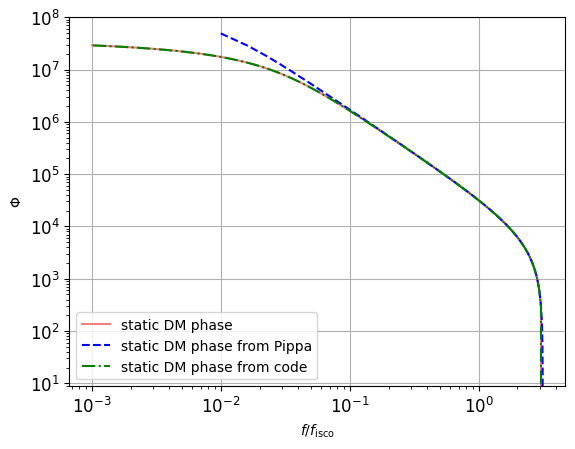

In [23]:
plt.loglog(freqs1, phase_dm_s1, c='lightcoral', linestyle='-', label='static DM phase')
plt.loglog(freqs_pippa, phase_pippa, c='blue', linestyle='--', label='static DM phase from Pippa')
plt.loglog(freqs1, check1._Phi_to_c_s(r_grid1), c='green', linestyle='-.', label='static DM phase from code')
plt.xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
plt.ylabel(r'$\Phi$', fontsize=10) 
plt.tick_params(axis='x', labelsize=12)  
plt.tick_params(axis='y', labelsize=12)  
plt.grid(True)
plt.legend();

## Checking with other codes (like $\texttt{pydd}$)

In [24]:
# Check

phase_check_dm_eff = check.phase_effective_dm(r_grid)
phase_check_dm_s = check._Phi_to_c_s(r_grid)
phase_check_vacuum = check._Phi_to_c_v(r_grid)

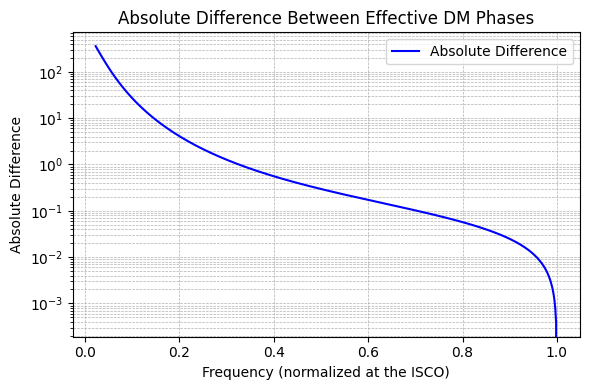

In [25]:
plt.figure(figsize=(6, 4))
plt.semilogy(freqs / f_isco, np.abs(phase_check_dm_eff - phase_dm_eff), label='Absolute Difference', color='blue', linestyle='-')
plt.xlabel('Frequency (normalized at the ISCO)')
plt.ylabel('Absolute Difference')
plt.title('Absolute Difference Between Effective DM Phases')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

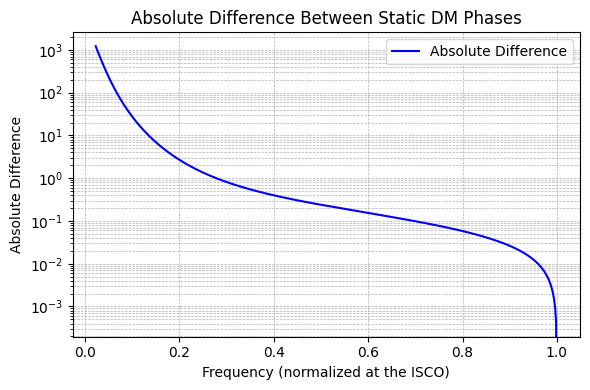

In [26]:
plt.figure(figsize=(6, 4))
plt.semilogy(freqs / f_isco, np.abs(phase_check_dm_s - phase_dm_s), label='Absolute Difference', color='blue', linestyle='-')
plt.xlabel('Frequency (normalized at the ISCO)')
plt.ylabel('Absolute Difference')
plt.title('Absolute Difference Between Static DM Phases')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

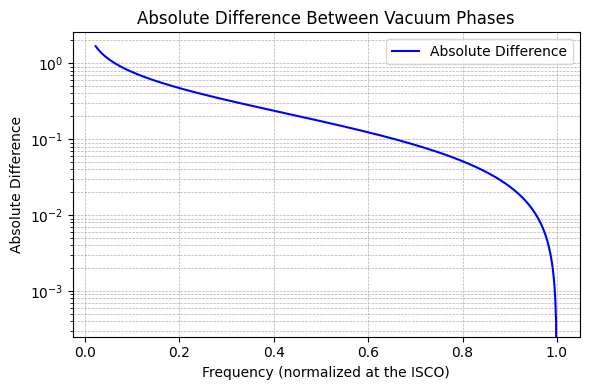

In [27]:
plt.figure(figsize=(6, 4))
plt.semilogy(freqs / f_isco, np.abs(phase_check_vacuum - phase_gw), label='Absolute Difference', color='blue', linestyle='-')
plt.xlabel('Frequency (normalized at the ISCO)')
plt.ylabel('Absolute Difference')
plt.title('Absolute Difference Between Vacuum Phases')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Is it sensed or maybe there is something wrong?

--- 

# Test 2) Multiple model parameters

We now work using the same functions as in the previous section, only varying parameters one by one (see also more specific work in $\texttt{Phase_extraction_DM_vs_Acc.ipynb}$). More specifically we'll change:

### For the accretion disk:

- The $\alpha$ parameter $\rightarrow \ [-0.4, -0.7]$ ($\beta$-disk regime), possibly changing the upper threshold to match an $\alpha$-disk. Particularly, the scaling relations go as: 

$$\Sigma_\alpha = 5.14 \cdot 10^3 (\frac{\alpha}{0.1})^{-1} (\frac{f_{\mathrm{edd}}}{0.1} \frac{0.1}{\epsilon})^{-1} (\frac{r}{10 M_1})^{3/2} \ \text{kg m}^{-2} ;$$

$$\Sigma_\beta = 2.1 \cdot 10^7 (\frac{\alpha}{0.1})^{-4/5} (\frac{f_{\mathrm{edd}}}{0.1} \frac{0.1}{\epsilon})^{3/5} (\frac{M_1}{10^6 M_{\odot}})^{1/5} (\frac{r}{10 M_1})^{-3/5}.$$

- $\Sigma_0$, just vary from some orders of magnitude and see which produces unphysical stuff; 
- $m_1$ from $1000 M_{\odot} \text{to} \ 10^6 M_{\odot}$. 

### For the dark matter spike:

- The $\gamma_s$ parameter $\rightarrow \ [2, 2.5]$;
- $\rho_m$, just vary from some orders of magnitude and see which produces unphysical stuff; 
- $m_1$ from $1000 M_{\odot} \text{to} \ 10^6 M_{\odot}$. 


We look to see how changing just one of these parameters will affect the inspiral. If the dephasing $\Delta\Phi$ increases, this means that the environmental effect is more likely to be detected, while the opposite indicates that a vacuum model will still be compatible with the phase measured. 

## Density normalizations ($\Sigma_0 \text{ vs } \rho_6$)

Will use the first parameters configuration.

In [28]:
sigma_0_i = np.logspace(7, 11, 20)
rho_6_i = np.logspace(14, 18, 20)

In [29]:
# Define models based on params

accretion_disk_density = [AccretionDisk(
    mach=Mach, 
    m1=m1,
    m2=m2, 
    dist=4e9,
    sigma0=sigma / Mach**2, 
    alpha=alpha,
    r0=r0
)for sigma in sigma_0_i]

dark_matter_density = [DarkMatter(
    m1=m1, 
    m2=m2, 
    dist=4e9, 
    q=q, 
    gammas=gammas, 
    rho6=rho * m_sun / pc**3, 
    r6=r6, 
    epsv=epsv
)for rho in rho_6_i]

### Dephasing

I here report the graphs only for the effective DM profile (for the static see $\texttt{Phase_extraction-DM_vs_Acc.ipynb}$ notebook).

In [30]:
# Produce matrix of dot_r

dot_r_dense = np.zeros((20, 20, 10000))

for i in range(0, len(dark_matter_density)):
    for j in range(0, len(accretion_disk_density)):
        
        dot_r_dense[i, j, :] = dark_matter_density[i].dot_r_dm_eff(r_grid) + accretion_disk_density[j].dot_r_acc(r_grid)

In [31]:
# Find dephasing

phase_all_dense = np.zeros((20, 20, 10000))

for i in range(0, len(dark_matter_density)):
    for j in range(0, len(accretion_disk_density)):
        
        phase_all_dense[i, j, :] = -phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid), dot_r_dense[i, j, :]))

In [32]:
N_all_dense = (-np.array(phase_all_dense) + np.array(phase_gw)) / (2 * np.pi)
print(N_all_dense.shape)

(20, 20, 10000)


In [33]:
# select components to see on plot

n_comp_to_see = [10, 500, 1000, 2000, 2500, 3000, 3500, 4000, 5000]

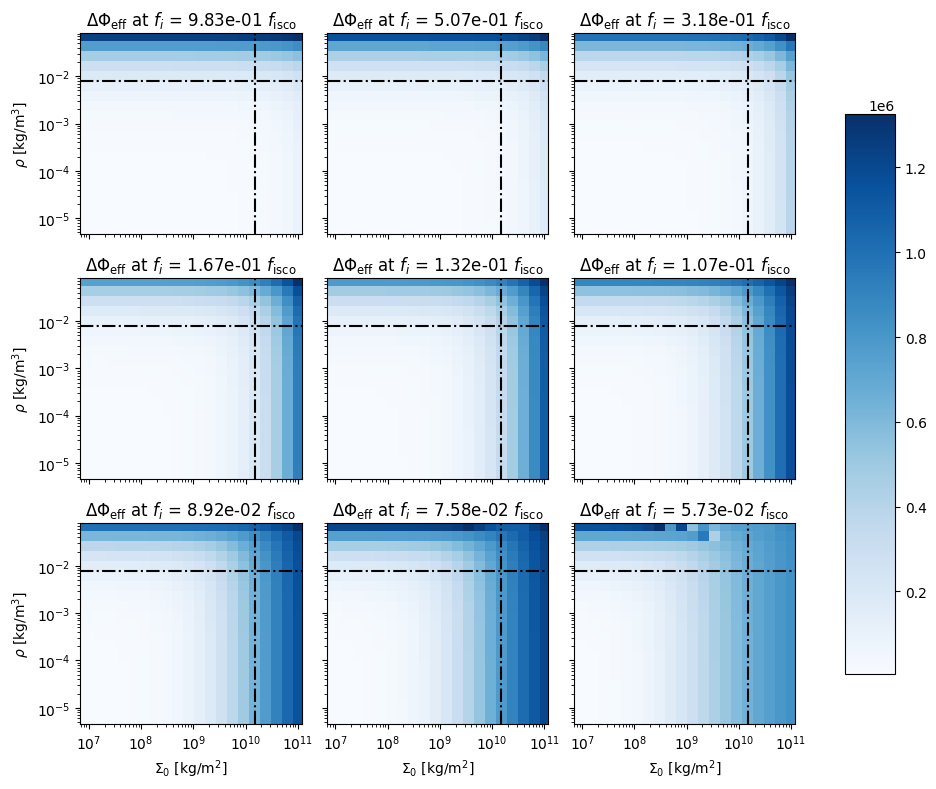

In [34]:
# Plot

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))

for ax, i in zip(axes.flat, n_comp_to_see):
    im = ax.pcolormesh(sigma_0_i, rho_6_i  * m_sun / (pc)**3, N_all_dense[:, :, i], cmap='Blues') 
    ax.axhline(y=1.17 * 1e17 * m_sun / (pc)**3, c='black', linestyle='-.', label='ref vals')
    ax.axvline(x=1.5 * 1e10, c='black', linestyle='-.')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('$\Sigma_0$ [kg/m$^2$]')
    ax.set_ylabel(r'$\rho$ [kg/m$^3$]')
    ax.label_outer()
    ax.set_title(f'$\Delta\Phi_{{\mathrm{{eff}}}}$ at $f_i$ = {freqs[i]/f_isco:.2e} $f_{{\mathrm{{isco}}}}$')    
    
fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig('results-images/phi_DELTA_densities_eff.png')

plt.show()

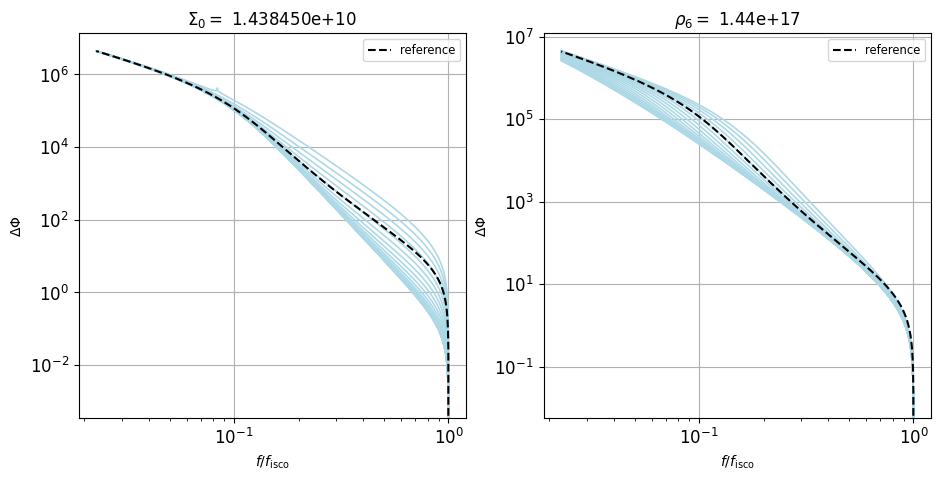

In [35]:
# Check multiple norm dephase

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

for i in range(0, 20):
    
    axes[0].loglog(freqs/f_isco, N_all_dense[i, 15, :], linestyle='-', linewidth=1.2, c='lightblue') # , label=fr'$\rho_6 =$ {rho_6_i[i]:2e}'
    
axes[0].loglog(freqs/f_isco, N_all, linestyle='--', linewidth=1.5, c='black', label='reference')
axes[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
axes[0].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].tick_params(axis='y', labelsize=12)  
axes[0].grid(True)
axes[0].set_title(fr'$\Sigma_0 = $ {sigma_0_i[15]:2e}')
axes[0].legend(fontsize='small')

for i in range(0, 20):
    
    axes[1].loglog(freqs/f_isco, N_all_dense[15, i, :], linestyle='-', linewidth=1.2, c='lightblue') #  label=fr'$\Sigma_0 =$ {sigma_0_i[i]:2e}'
    
axes[1].loglog(freqs/f_isco, N_all, linestyle='--', linewidth=1.5, c='black', label='reference')
axes[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
axes[1].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].tick_params(axis='y', labelsize=12)  
axes[1].grid(True)
axes[1].set_title(fr'$\rho_6 =$ {rho_6_i[15]:.2e}')
axes[1].legend(fontsize='small');

## Density slopes ($\gamma_s \text{ vs } \alpha$)

In [36]:
alpha_i = np.linspace(-0.7, 1.5, 20)
gamma_s_i = np.linspace(2, 2.5, 20)

In [37]:
# Define models based on params

accretion_disk_slope = [AccretionDisk(
    mach=Mach, 
    m1=m1,
    m2=m2, 
    dist=4e9,
    sigma0=sigma0, 
    alpha=alpha,
    r0=r0
)for alpha in alpha_i]

dark_matter_slope = [DarkMatter(
    m1=m1, 
    m2=m2, 
    dist=4e9, 
    q=q, 
    gammas=gamma, 
    rho6=rho6, 
    r6=r6, 
    epsv=epsv
)for gamma in gamma_s_i]

In [38]:
# Produce matrix of dot_r

dot_r_slope = np.zeros((20, 20, 10000))

for i in range(0, len(dark_matter_slope)):
    for j in range(0, len(accretion_disk_slope)):
        
        dot_r_slope[i, j, :] = dark_matter_slope[i].dot_r_dm_eff(r_grid) + accretion_disk_slope[j].dot_r_acc(r_grid)

In [39]:
# Find dephasing

phase_all_slope = np.zeros((20, 20, 10000))

for i in range(0, len(dark_matter_slope)):
    for j in range(0, len(accretion_disk_slope)):
        
        phase_all_slope[i, j, :] = -phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid), dot_r_slope[i, j, :]))

In [40]:
N_all_slope = (-np.array(phase_all_slope) + np.array(phase_gw)) / (2 * np.pi)
print(N_all_slope.shape)

(20, 20, 10000)


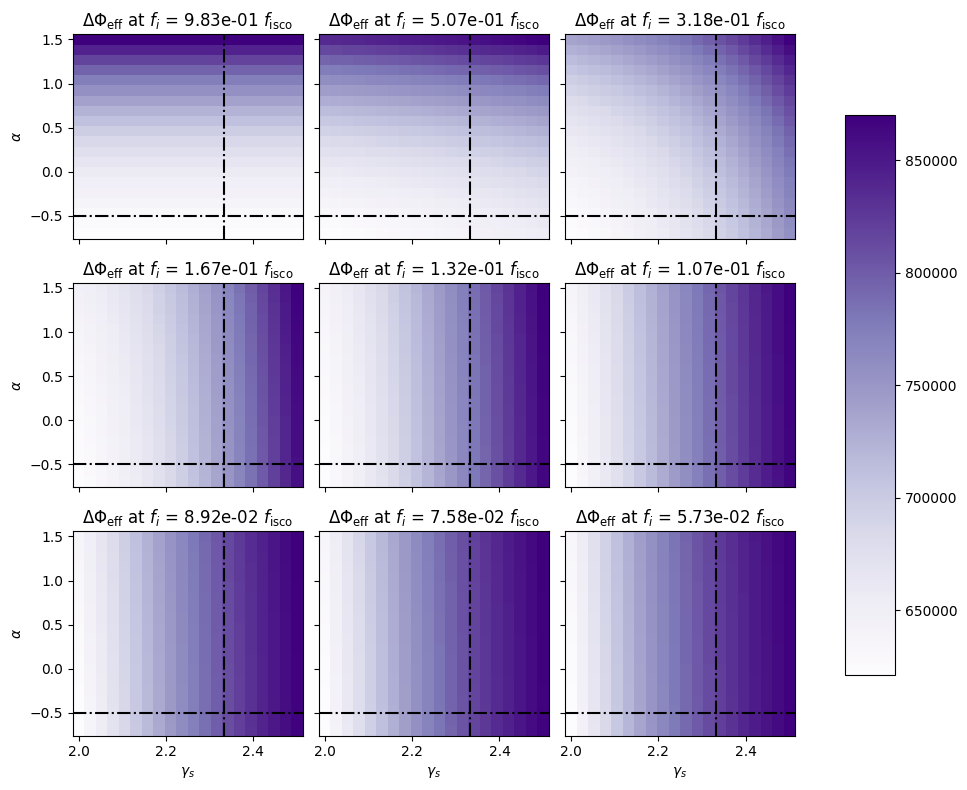

In [41]:
# Plot

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))

for ax, i in zip(axes.flat, n_comp_to_see):
    im = ax.pcolormesh(gamma_s_i, alpha_i, N_all_slope[:, :, i], cmap='Purples') 
    ax.axvline(x=7/3, c='black', linestyle='-.', label='ref vals')
    ax.axhline(y=-0.5, c='black', linestyle='-.')
    ax.set_ylabel(r'$\alpha$')
    ax.set_xlabel(r'$\gamma_s$')
    ax.label_outer()
    ax.set_title(f'$\Delta\Phi_{{\mathrm{{eff}}}}$ at $f_i$ = {freqs[i]/f_isco:.2e} $f_{{\mathrm{{isco}}}}$')
    
fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig('results-images/phi_DELTA_slopes_eff.png')

plt.show()

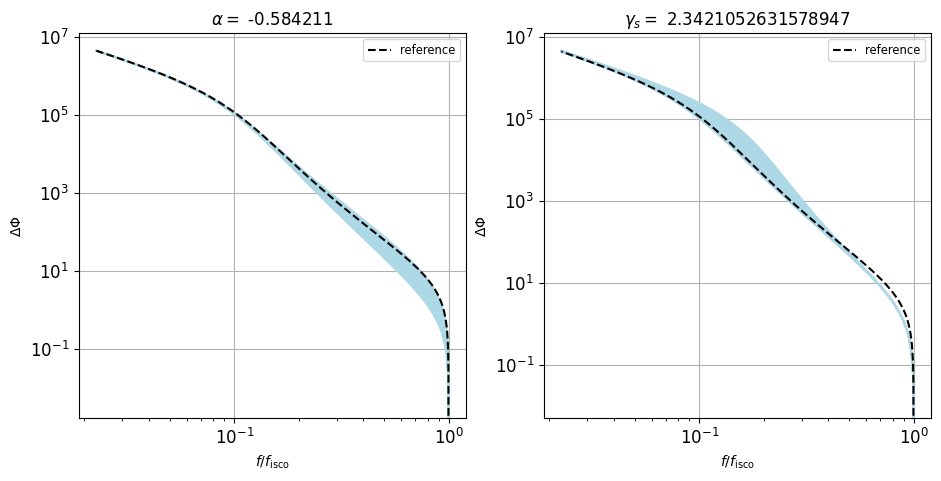

In [42]:
# Check multiple slope dephase

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

for i in range(0, 20):
    
    axes[0].loglog(freqs/f_isco, N_all_slope[i, 1, :], linestyle='-', linewidth=1.2, c='lightblue') # , label=f'$\gamma_s =$ {gamma_s_i[i]:2f}'
    
axes[0].loglog(freqs/f_isco, N_all, linestyle='--', linewidth=1.5, c='black', label='reference')  
axes[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
axes[0].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].tick_params(axis='y', labelsize=12)  
axes[0].grid(True)
axes[0].set_title(fr'$\alpha = $ {alpha_i[1]:2f}')
axes[0].legend(fontsize='small')

for i in range(0, 20):
    
    axes[1].loglog(freqs/f_isco, N_all_slope[13, i, :], linestyle='-', linewidth=1.2, c='lightblue') # label=fr'$\alpha =$ {alpha_i[i]:2f}'
    
axes[1].loglog(freqs/f_isco, N_all, linestyle='--', linewidth=1.5, c='black', label='reference')  
axes[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
axes[1].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].tick_params(axis='y', labelsize=12)  
axes[1].grid(True)
axes[1].set_title(fr'$\gamma_s =$ {gamma_s_i[13]}')
axes[1].legend(fontsize='small');

---

# Test 3) Benchmark value for $\rho_{\mathrm{dm}}$

We need to now use our models varying the parameter $\rho_{\mathrm{dm}}$ until we find a condition for which two phases with different environments are comparable. To do so, we need to build a function that, fixing the frequency at which we want to evaluate the minimum distance between dephases, returns the curve with the optimal parameters satisfying this condition. Indeed the dephasing should be minimal when accretion and dark matter have the same weight. 

I will test two conditions:

- $\Delta\Phi_{\mathrm{dm, static}} \simeq \Delta\Phi_{\mathrm{acc}}$

- $\Delta\Phi_{\mathrm{dm, efficient}} \simeq \Delta\Phi_{\mathrm{acc}}$

In [43]:
# Build grid of vals

f_LISA = 1e-3 # Hz
r_max_b = vacuum_binary.radius(f_LISA)

r_isco_b = 6 * m1 * G / c**2
f_isco_b = vacuum_binary.frequency(r_isco_b)

print('isco frequency', f_isco_b)

# set grid of radial distances
r_grid_b = np.linspace(r_isco_b, r_max_b, 10000 * 5)
freqs_b = vacuum_binary.frequency(r_grid_b)

isco frequency 0.04397229680540114


In [44]:
# Find coalescence time by integration

def time_to_coal_by_hand(freqs, df_dt):
    
    '''Finds the coalescence time (assuming all the environments) integrating over the frequency domain.'''
    
    to_integrate = (df_dt)**-1
    t_coal_f = []
    
    for f_low in freqs:
        f_range = freqs[freqs >= f_low]
        t_coal_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
    
    return np.array(t_coal_f)

# Find coalescence time by integration

def time_to_coal(freqs, df_dt):
    
    '''Finds the coalescence time (assuming all the environments) integrating over the frequency domain.'''
    
    to_integrate = df_dt**(-1) 

    # Compute the cumulative integral of the function using trapezoidal rule --> much faster way
    t_coal_f = cumulative_trapezoid(to_integrate, x=freqs, initial=0)
    
    return np.array(t_coal_f)

In [45]:
# Find df_dt with which to work

df_dt_coal = df_dt(vacuum_binary.df_dr(r_grid_b), dark_matter.dot_r_dm_s(r_grid_b) + vacuum_binary.dot_r_gw(r_grid_b))

In [46]:
time_to_coal_data = -time_to_coal(freqs_b, df_dt_coal)
f_1yr = np.interp(3.156e7, time_to_coal_data, freqs_b) / f_isco_b

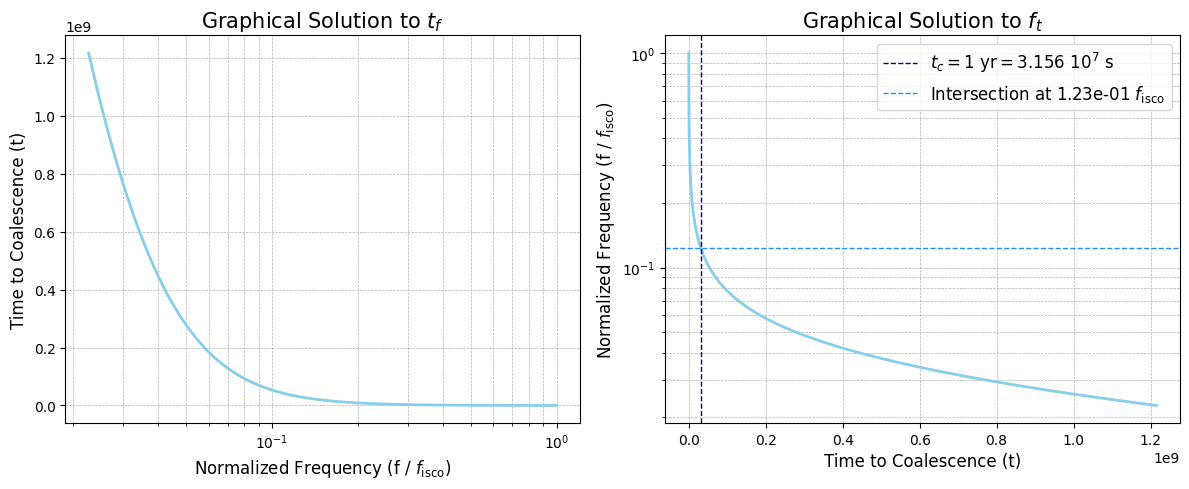

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[1].semilogy(time_to_coal_data, freqs_b / f_isco, c='skyblue', linewidth=2)
ax[1].set_xlabel('Time to Coalescence (t)', fontsize=12)
ax[1].set_ylabel('Normalized Frequency (f / $f_{\mathrm{isco}}$)', fontsize=12)

ax[0].semilogx(freqs_b / f_isco, time_to_coal_data, c='skyblue', linewidth=2)
ax[0].set_ylabel('Time to Coalescence (t)', fontsize=12)
ax[0].set_xlabel('Normalized Frequency (f / $f_{\mathrm{isco}}$)', fontsize=12)
ax[0].grid(True, which="both", linestyle='--', linewidth=0.5)

ax[1].axvline(3.156e7, c='darkblue', linestyle='--', label=f'$t_c = 1 \ \mathrm{{yr}} = 3.156 \ 10^7 \ \mathrm{{s}}$', linewidth=1)
ax[1].axhline(f_1yr, c='dodgerblue', linestyle='--', label=f'Intersection at {f_1yr:.2e} $f_{{\mathrm{{isco}}}}$', linewidth=1)
ax[1].grid(True, which="both", linestyle='--', linewidth=0.5)

ax[1].set_title('Graphical Solution to $f_t$', fontsize=15)
ax[0].set_title('Graphical Solution to $t_f$', fontsize=15)

plt.legend(fontsize='large')

plt.tight_layout()
plt.show()

In [48]:
# Increase rho_s_i grid size

rho_6_i_LARGE = np.logspace(14, 18, 100)

In [49]:
dark_matter_bench = [DarkMatter(
    m1=m1, 
    m2=m2, 
    dist=4e9, 
    q=q, 
    gammas=7/3, 
    rho6=rho * m_sun / pc**3, 
    r6=r6, 
    epsv=epsv
)for rho in rho_6_i_LARGE]

### Dephasing

In [50]:
phase_dm_s_bench = []
phase_dm_eff_bench = []

for i in range(0, len(rho_6_i_LARGE)):

    phase_dm_s_bench.append(phase_f(freqs_b, df_dt(vacuum_binary.df_dr(r_grid_b), dark_matter_bench[i].dot_r_dm_s(r_grid_b) + vacuum_binary.dot_r_gw(r_grid_b))))
    phase_dm_eff_bench.append(phase_f(freqs_b, df_dt(vacuum_binary.df_dr(r_grid_b), dark_matter_bench[i].dot_r_dm_eff(r_grid_b))))

In [51]:
phase_gw_bench = vacuum_binary.vacuum_phase(r_grid_b)
phase_acc_bench = phase_f(freqs_b, df_dt(vacuum_binary.df_dr(r_grid_b), accretion_disk.dot_r_acc(r_grid_b) + vacuum_binary.dot_r_gw(r_grid_b)))

In [52]:
# N-cycles

N_dm_s_bench   = []
N_dm_eff_bench = []

for i in range(0, len(rho_6_i_LARGE)):

    N_dm_s_bench.append(np.array(phase_dm_s_bench[i]) - np.array(phase_gw_bench))
    N_dm_eff_bench.append(np.array(phase_dm_eff_bench[i]) - np.array(phase_gw_bench))

N_acc_bench = np.array(phase_acc_bench) - np.array(phase_gw_bench)

In [53]:
def find_dm_benchmark_1(N_cycles_1, N_cycles_2, rho_dm, f_ref):
    
    '''Finds the benchmark value for dark matter fixing the reference frequency, using two dephasings with same dimensions.'''
    
    i = np.where(freqs_b/f_isco < f_ref)[0][0]
    delta_N_cycles = np.array([np.abs(N_cycles_1[j][i] - N_cycles_2[j][i]) for j in range(0, len(N_cycles_1))]) 
    
    i_min = np.where(delta_N_cycles == np.min(delta_N_cycles))[0][0]
    
    return rho_dm[i_min]

def find_dm_benchmark_2(N_cycles_array, N_cycles, rho_dm, f_ref):
    
    '''Finds the benchmark value for dark matter fixing the reference frequency, using two dephasings with different dimensions.'''
    
    i = np.where(freqs_b/f_isco < f_ref)[0][0]
    delta_N_cycles = np.array([np.abs(N_cycles_array[j][i] - N_cycles[i]) for j in range(0, len(N_cycles_array))])     
    i_min = np.where(delta_N_cycles == np.min(delta_N_cycles))[0][0]
    
    return rho_dm[i_min], i_min

def find_dm_benchmark_3(N_cycles_array, N_cycles, rho_dm, f_ref):
    
    '''Finds the benchmark value for dark matter fixing the reference frequency, using two dephasings with different dimensions.'''
    
    i = np.where(freqs_b/f_isco < f_ref)[0][0]
    delta_N_cycles = np.array([np.abs(N_cycles_array[j][i] - N_cycles[i]) for j in range(0, len(N_cycles_array))])     
    i_min = np.where(delta_N_cycles == np.min(delta_N_cycles))[0][0]
    
    return i_min, rho_dm[i_min]

Finding the threshold, finally!

In [54]:
i_max_s, rho_optimal_static_max = find_dm_benchmark_3(N_dm_s_bench, N_acc_bench, rho_6_i_LARGE, f_1yr)
i_min_s, rho_optimal_static_min = find_dm_benchmark_3(N_dm_s_bench, N_acc_bench, rho_6_i_LARGE, 1) # 1 = f_isco / f_isco

print('rho benchmark = [', f'{rho_optimal_static_min:.7e}, {rho_optimal_static_max:.7e}] M_sun / pc^3')

rho benchmark = [ 4.5348785e+15, 5.2140083e+17] M_sun / pc^3


In [55]:
i_max_eff, rho_optimal_eff_max = find_dm_benchmark_3(N_dm_eff_bench, N_acc_bench, rho_6_i_LARGE, f_1yr)
i_min_eff, rho_optimal_eff_min = find_dm_benchmark_3(N_dm_eff_bench, N_acc_bench, rho_6_i_LARGE, 1)

print('rho benchmark = [', f'{rho_optimal_eff_min:.7e}, {rho_optimal_eff_max:.7e}] M_sun / pc^3')

rho benchmark = [ 1.0476158e+16, 4.7508102e+17] M_sun / pc^3


### Plotting results

In [56]:
# Blue tone color palette
colors = {
    'light_lines': 'lightblue',
    'max_line': 'dodgerblue',
    'min_line': 'darkblue',
    'accretion_line': 'navy',
    'vline1': 'cornflowerblue',
    'vline2': 'royalblue'
}

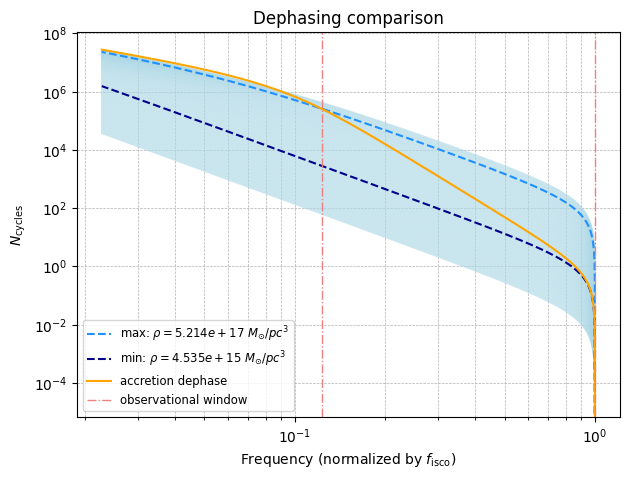

In [57]:
plt.figure(figsize=(7, 5))

# Plotting the dephasing data
for i in range(0, len(N_dm_s_bench)):
    plt.loglog(freqs_b / f_isco, N_dm_s_bench[i], c=colors['light_lines'], linewidth=1, alpha=0.6)

plt.loglog(freqs_b / f_isco, N_dm_s_bench[i_max_s], c=colors['max_line'], linewidth=1.5, label=fr'max: $\rho = {rho_optimal_static_max:.3e} \ M_{{\odot}} / pc^3$', linestyle='--')
plt.loglog(freqs_b / f_isco, N_dm_s_bench[i_min_s], c=colors['min_line'], linewidth=1.5, label=fr'min: $\rho = {rho_optimal_static_min:.3e} \ M_{{\odot}} / pc^3$', linestyle='--')
plt.loglog(freqs_b / f_isco, N_acc_bench, c='orange', linewidth=1.5, label='accretion dephase')

# Adding vertical lines
plt.axvline(x=f_1yr, c='lightcoral', linestyle='-.', label='observational window', linewidth=1)
plt.axvline(x=1, c='lightcoral', linestyle='-.', linewidth=1)

# Grid, title, labels
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.title('Dephasing comparison', fontsize=12)
plt.xlabel('Frequency (normalized by $f_{\mathrm{isco}}$)')
plt.ylabel('$N_{\mathrm{cycles}}$')

# Adjust legend
plt.legend(fontsize='small', loc='lower left')

# Save and show plot
plt.savefig('results-images/dephasing_comparison_static.png')
plt.show()

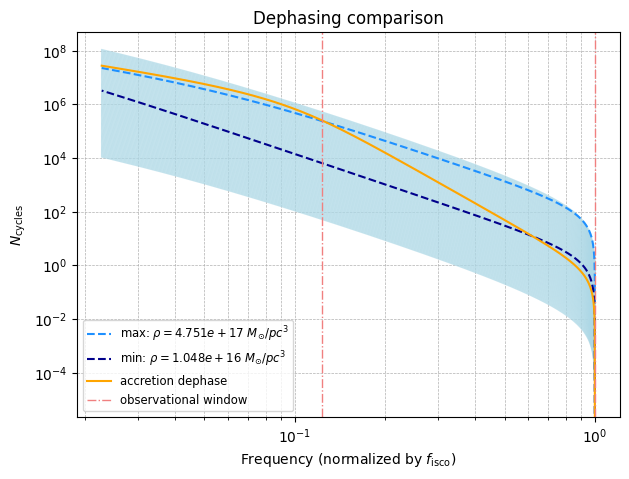

In [58]:
plt.figure(figsize=(7, 5))

for i in range(0, len(N_dm_s_bench)):
    plt.loglog(freqs_b / f_isco, N_dm_eff_bench[i], c='lightblue', linewidth=1, alpha=0.7)

plt.loglog(freqs_b / f_isco, N_dm_s_bench[i_max_eff], c=colors['max_line'], linewidth=1.5, label=fr'max: $\rho = {rho_optimal_eff_max:.3e} \ M_{{\odot}} / pc^3$', linestyle='--')
plt.loglog(freqs_b / f_isco, N_dm_s_bench[i_min_eff], c=colors['min_line'], linewidth=1.5, label=fr'min: $\rho = {rho_optimal_eff_min:.3e} \ M_{{\odot}} / pc^3$', linestyle='--')
plt.loglog(freqs_b / f_isco, N_acc_bench, c='orange', linewidth=1.5, label='accretion dephase')

# Adding vertical lines
plt.axvline(x=f_1yr, c='lightcoral', linestyle='-.', label='observational window', linewidth=1)
plt.axvline(x=1, c='lightcoral', linestyle='-.', linewidth=1)

# Grid, title, labels
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.title('Dephasing comparison')
plt.xlabel('Frequency (normalized by $f_{\mathrm{isco}}$)')
plt.ylabel('$N_{\mathrm{cycles}}$')

# Adjust legend
plt.legend(fontsize='small', loc='lower left')

# Save and show plot
plt.savefig('results-images/dephasing_comparison_effect.png')
plt.show()